# Problem Set 2: Window based Stereo Matching
---
## Setup

In [48]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. SSD Stereo (Simple Image)

In [4]:
# Load images
img1l = cv2.imread('Data/leftTest.png', 0)
img1l = img1l.astype(np.float32) / 255
img1r = cv2.imread('Data/rightTest.png', 0)
img1r = img1r.astype(np.float32) / 255

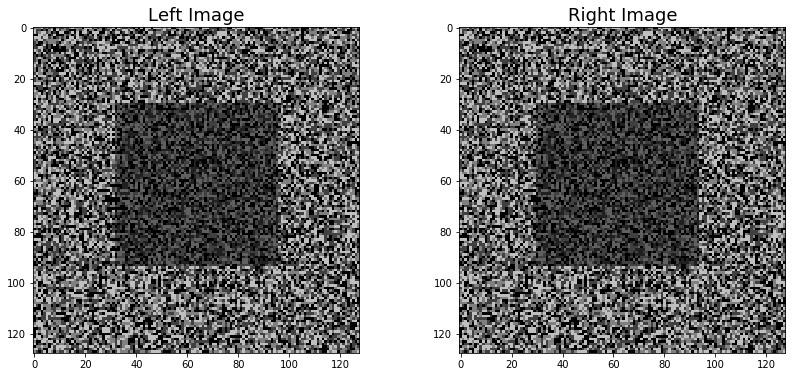

In [5]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Left Image')
ax[0].imshow(img1l, clim=(0,1))
ax[1].set_title('Right Image')
ax[1].imshow(img1r, clim=(0,1));

In [105]:
def disparity_ssd(imgl, imgr, window_size=11, max_offset=100):
    # Only odd kernels
    assert(window_size%2 == 1)
    # Check dims
    assert(imgl.shape == imgr.shape)
    # Initializations
    k = window_size // 2
    h, w = imgl.shape
    # Summing kernel
    kernel = np.ones((window_size, window_size), np.float)
    # Accumulators
    ssdl = np.inf * np.ones((h, w, max_offset+1), np.float)
    ssdr = np.inf * np.ones((h, w, max_offset+1), np.float)
    for offset in range(max_offset+1):
        sd = (imgl[:, offset:] - imgr[:, :w-offset]) ** 2
        ssdl[k:-k, k+offset:-k, offset] = ssdr[k:-k, k:-k-offset, offset] = correlate2d(sd, kernel, mode='valid')
    # Disparity images
    factor = 1.0 / max_offset
    depthl = ssdl.argmin(-1) * factor
    depthr = ssdr.argmin(-1) * factor
    return depthl, depthr

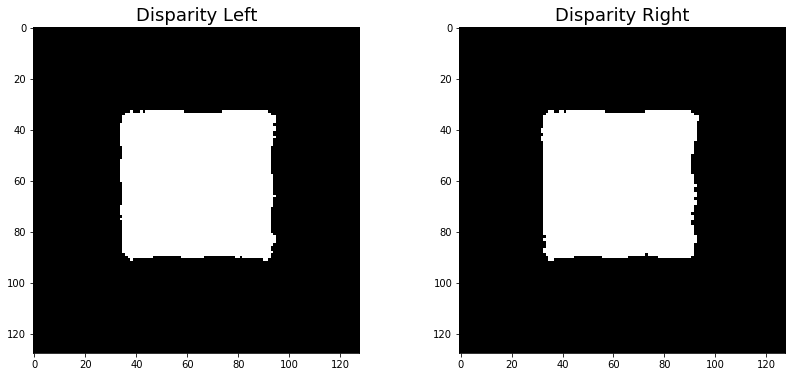

In [47]:
Dl1, Dr1 = disparity_ssd(img1l, img1r, max_offset=2)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity Left')
ax[0].imshow(Dl1, clim=(0,1))
ax[1].set_title('Disparity Right')
ax[1].imshow(Dr1, clim=(0,1));

---
## 2. SSD Stereo (First Image)

In [68]:
# Load images
img2l = cv2.imread('Data/proj2-pair1-L.png', 0)
img2l = img2l.astype(np.float32) / 255
img2r = cv2.imread('Data/proj2-pair1-R.png', 0)
img2r = img2r.astype(np.float32) / 255

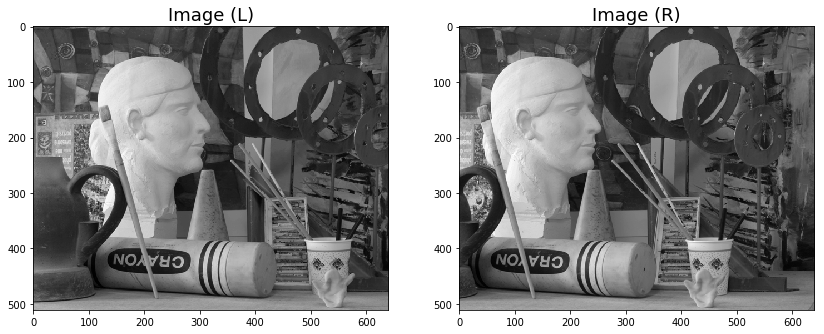

In [9]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L)')
ax[0].imshow(img2l)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

### a. Disparity Images

In [10]:
# Calculate Disparity
Dl2, Dr2 = disparity_ssd(img2l, img2r, window_size=11, max_offset=100)

### b. Comparison to Ground Truth

In [11]:
# Load ground truth
img2lgt = cv2.imread('Data/proj2-pair1-Disp-L.png', 0)
img2lgt = img2lgt.astype(np.float32) / 255
img2rgt = cv2.imread('Data/proj2-pair1-Disp-R.png', 0)
img2rgt = img2rgt.astype(np.float32) / 255

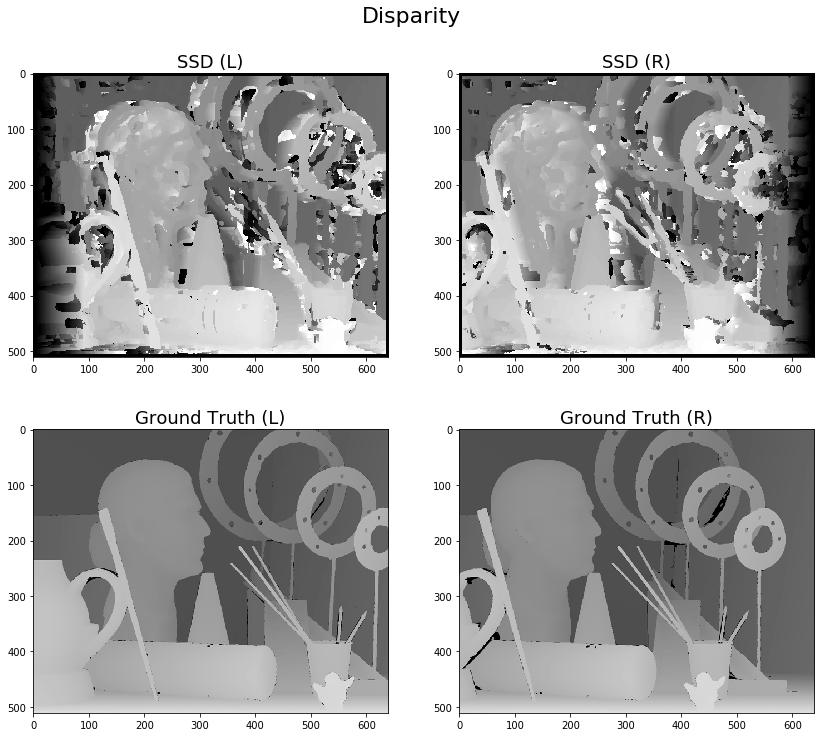

In [12]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('SSD (L)')
ax[0, 0].imshow(Dl2, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img2lgt, clim=(0,1));
ax[0, 1].set_title('SSD (R)')
ax[0, 1].imshow(Dr2, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img2rgt, clim=(0,1));

---
## 3. SSD Stereo: Effect of Perturbations (First Image)
### a. Noise

In [13]:
# Noise Params
sigma = 0.05
noise = np.random.normal(0, sigma, img2l.shape)
# Add noise
img2ln = np.add(img2l, noise)
img2ln = img2ln.clip(0.0, 1.0)

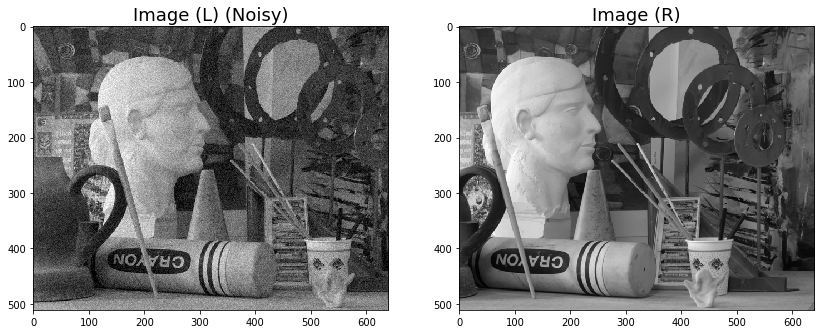

In [14]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L) (Noisy)')
ax[0].imshow(img2ln)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

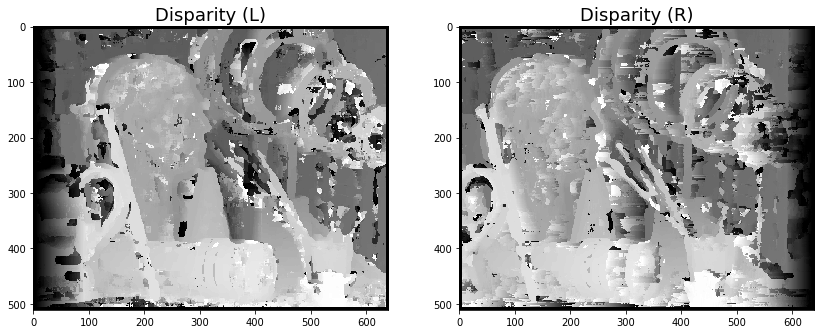

In [15]:
Dln2, Drn2 = disparity_ssd(img2ln, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dln2, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drn2, clim=(0,1));

### b. Different Contrasts

In [16]:
# Increase contrast
img2lc = 1.1 * img2l
img2lc = img2lc.clip(0.0, 1.0)

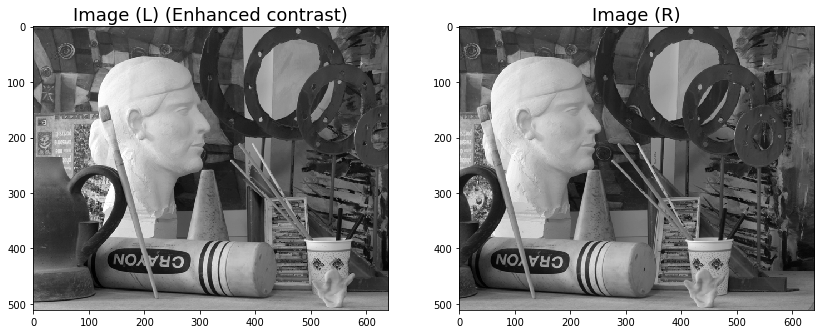

In [17]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L) (Enhanced contrast)')
ax[0].imshow(img2lc)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

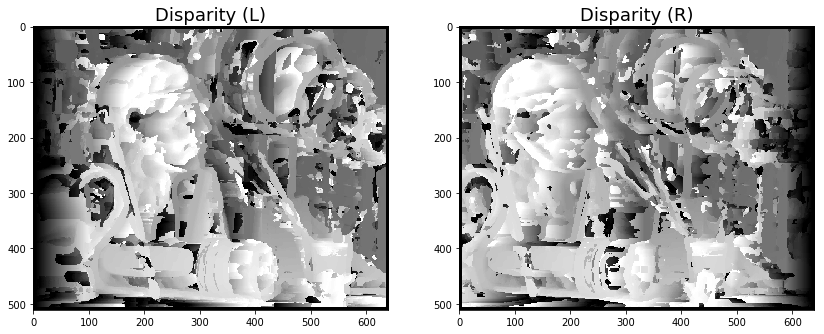

In [18]:
Dlc2, Drc2 = disparity_ssd(img2lc, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dlc2, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drc2, clim=(0,1));

---
## 4. Normalized Correlation Stereo (First Image)
### a. First Image

In [103]:
def disparity_ncorr(imgl, imgr, window_size=11, max_offset=100):
    # Only odd kernels
    assert(window_size % 2 == 1)
    # Check dims
    assert(imgl.shape == imgr.shape)
    # Initializations
    k = window_size // 2 
    h, w = imgl.shape
    # Accumulators
    ssdl = np.zeros((h, w, max_offset+1), np.float)
    ssdr = np.zeros((h, w, max_offset+1), np.float)
    for y in range(k, h-k):
        for x in range(k, w-k):
            if x-k-max_offset < 0:
                ssdl[y, x, :x-k-max_offset] = np.fliplr(cv2.matchTemplate(imgr[y-k:y+k+1, :x+k+1], imgl[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED))
            else:
                ssdl[y, x, :] = np.fliplr(cv2.matchTemplate(imgr[y-k:y+k+1, x-k-max_offset:x+k+1], imgl[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED))
            if x+k+max_offset+1 > w:
                 ssdr[y, x, :w-(x+k+1+max_offset)] = cv2.matchTemplate(imgl[y-k:y+k+1, x-k:], imgr[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED)
            else:
                ssdr[y, x, :] = cv2.matchTemplate(imgl[y-k:y+k+1, x-k:x+k+1+max_offset], imgr[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED)
    # Disparity images
    factor = 1.0 / max_offset
    depthl = ssdl.argmax(-1) * factor
    depthr = ssdr.argmax(-1) * factor
    return depthl, depthr

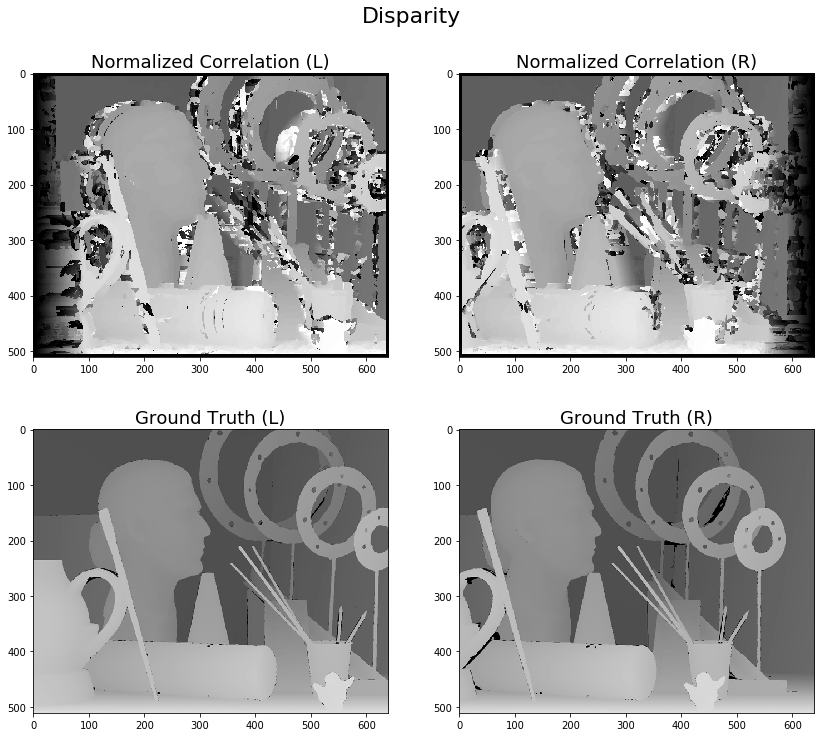

In [104]:
Dl2ncorr, Dr2ncorr = disparity_ncorr(img2l, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('Normalized Correlation (L)')
ax[0, 0].imshow(Dl2ncorr, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img2lgt, clim=(0,1));
ax[0, 1].set_title('Normalized Correlation (R)')
ax[0, 1].imshow(Dr2ncorr, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img2rgt, clim=(0,1));

### b. Perturbations
#### i. Noise

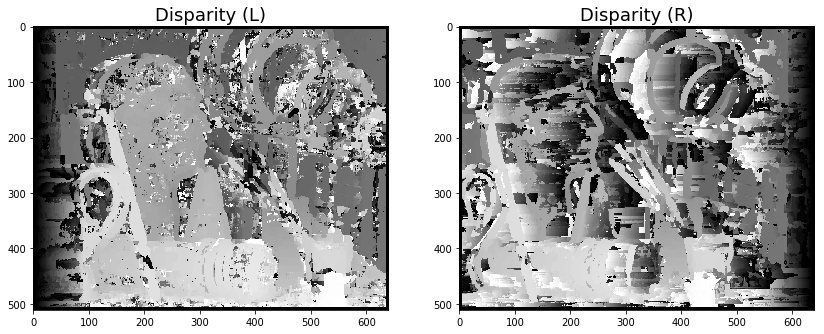

In [21]:
Dln2ncorr, Drn2ncorr = disparity_ncorr(img2ln, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dln2ncorr, clim=(0,1));
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drn2ncorr, clim=(0,1));

#### ii. Different Contrasts

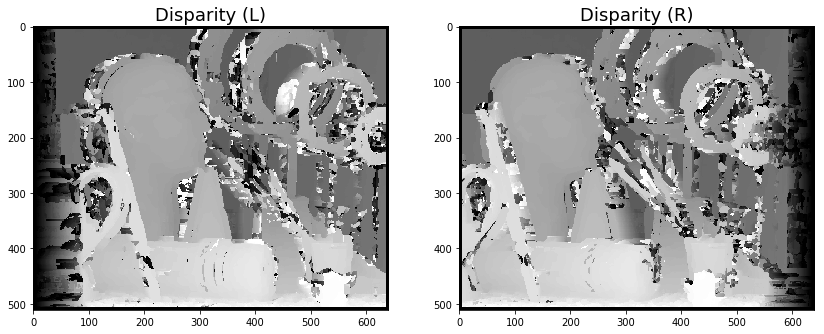

In [22]:
Dlc2ncorr, Drc2ncorr = disparity_ncorr(img2lc, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dlc2ncorr, clim=(0,1));
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drc2ncorr, clim=(0,1));

---
## 5. Stereo (Second Image)

In [23]:
# Load images
img3l = cv2.imread('Data/proj2-pair2-L.png', 0)
img3l = img3l.astype(np.float32) / 255
img3r = cv2.imread('Data/proj2-pair2-R.png', 0)
img3r = img3r.astype(np.float32) / 255

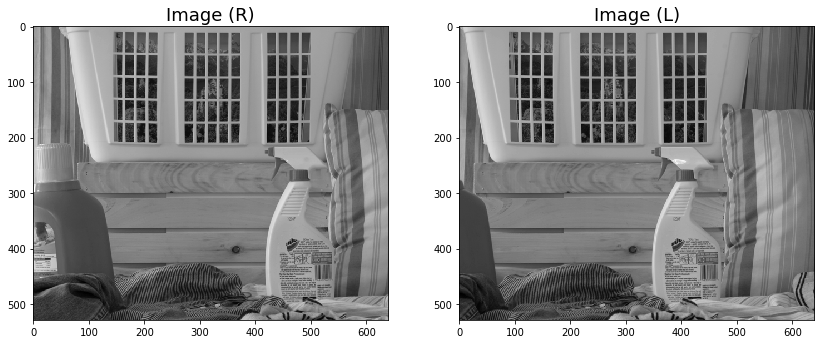

In [24]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (R)')
ax[0].imshow(img3l)
ax[1].set_title('Image (L)')
ax[1].imshow(img3r);

In [25]:
# Load ground truth
img3lgt = cv2.imread('Data/proj2-pair2-Disp-L.png', 0)
img3lgt = img3lgt.astype(np.float32) / 255
img3rgt = cv2.imread('Data/proj2-pair2-Disp-R.png', 0)
img3rgt = img3rgt.astype(np.float32) / 255

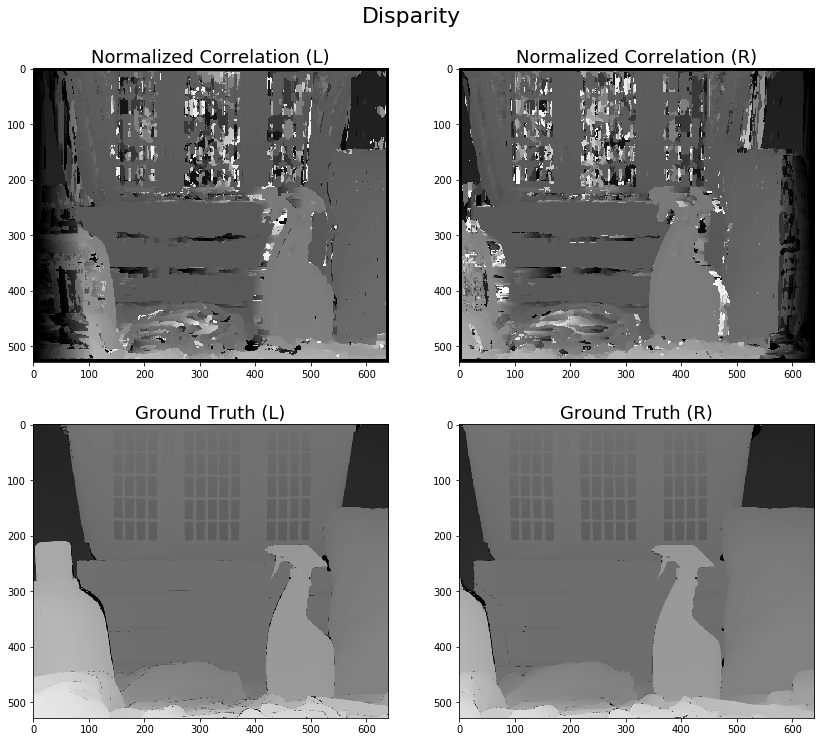

In [26]:
Dl3ncorr, Dr3ncorr = disparity_ncorr(img3l, img3r, window_size=11, max_offset=150)
# Plot
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('Normalized Correlation (L)')
ax[0, 0].imshow(Dl3ncorr, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img3lgt, clim=(0,1));
ax[0, 1].set_title('Normalized Correlation (R)')
ax[0, 1].imshow(Dr3ncorr, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img3rgt, clim=(0,1));